# NDVI Calculation

In [1]:
import sys
sys.path.append('../')

In [2]:
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import lithops
import time
import shutil
import os
import gc
import datetime
import math
import collections
from rasterio.io import MemoryFile
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from IPython import display

import cloudbutton_geospatial.s2froms3 as s2froms3
from cloudbutton_geospatial.utils import notebook as notebook_utils
from cloudbutton_geospatial.io_utils.ndvi import get_ndvi_params, ndvi_calculation, ndvi_tile_sentinel, get_subset_raster, lonlat_to_utm, get_poly_within
from cloudbutton_geospatial.io_utils.plot import tiff_overview, plot_map

%matplotlib inline

## Input parameters

Select the date interval in which tiles will be processed:

In [3]:
default_from = datetime.date(year=2019, month=9, day=17)
default_to = datetime.date(year=2020, month=9, day=16)

from_date, to_date = notebook_utils.pick_date_range(default_from, default_to)

DatePicker(value=datetime.date(2019, 9, 17), description='From day')

DatePicker(value=datetime.date(2020, 9, 16), description='To day')

Select the tile's cloud percentage threshold:

In [4]:
percentage = notebook_utils.pick_percentage_slider()

IntSlider(value=15, continuous_update=False, description='Percentage of cloudiness')

## Find tiles

Select the area which delimites the tiles you want to process (left click to mark a point in the map, right click to erase current selection):

In [5]:
# map_region = notebook_utils.MapRegion(center=(39.60595289727246, -122.82804126978336))

In [6]:
# coord = map_region.get_region()[0]
# lat = coord[1]  # latitude
# lon = coord[0]  # longitude
# print(lat, lon)

In [7]:
start_date = from_date.value  # Start date to search images
end_date = to_date.value  # End date to search images
what = ['B04', 'B08']  # What we want to download
cc = percentage.value  # Minimum cloud cover on each image, 25 is 25%

In [8]:
# Demonstration: Californa tile coords
cali_coords = [
    [38.510161585585045, -122.99194335937501],
    [36.071996052851325, -121.25610351562501],
    [36.96374622851412, -121.46484375000001],
    [37.575739257598414, -121.55273437500001],
    [39.15202827678992, -122.62939453125001],
    [39.703620879017976, -123.12377929687501],
    [36.74397383313428, -119.94873046875001],
    [38.472809653752314, -121.60766601562501]
]

## Get Sentinel-2 packages

In [9]:
iterdata = []
scenes_f1_all = []
scenes_f2_all = []

# coords = map_region.get_region()[1:]
coords = cali_coords

for coord in coords:
    lat = coord[0]  # latitude
    lon = coord[1]  # longitude
      
    # Get scenes from intital date
    scenes_f1 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                        start_date=start_date,
                                        end_date=start_date,
                                        what=what,
                                        cloud_cover_le=cc)
    scenes_f1_all.extend(scenes_f1)
    print(f'Found scenes {start_date}:', scenes_f1)

    # get scenes from end date
    scenes_f2 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                        start_date=end_date,
                                        end_date=end_date,
                                        what=what,
                                        cloud_cover_le=cc)
    print(f'Found scenes {end_date}:', scenes_f2)
    scenes_f2_all.extend(scenes_f2)

    scene = scenes_f1[-1]
    scene_band = rasterio.open('s3://'+scene[0])
    windows = list(scene_band.block_windows())
    tile_iterdata = [(scenes_f1[0], scenes_f2[0], wd) for wd in windows]
    iterdata.extend(tile_iterdata)

Found scenes 2019-09-17: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2019/9/S2A_10SEH_20190917_0_L2A/B08.tif')]
Found scenes 2020-09-16: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EH/2020/9/S2B_10SEH_20200916_0_L2A/B08.tif')]
Found scenes 2019-09-17: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FE/2019/9/S2A_10SFE_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FE/2019/9/S2A_10SFE_20190917_0_L2A/B08.tif')]
Found scenes 2020-09-16: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FE/2020/9/S2B_10SFE_20200916_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FE/2020/9/S2B_10SFE_20200916_0_L2A/B08.tif')]
Found scenes 2019-09-17: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FF/2019/9/S2A_10SFF_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/FF/2019/9/S2A_10SFF_20190917_0_L2A/B08.tif')]


In [10]:
tile_band_keys = [tup[0] for tup in scenes_f1_all]

In [11]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='INFO',
        runtime_memory=1024,
        runtime='aitorarjona/cloudbutton-ndvi:01'  # Runtime for AWS Lambda
)

2022-06-10 10:04:04,443 [INFO] lithops.config -- Lithops v2.6.0
2022-06-10 10:04:04,558 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-1
2022-06-10 10:04:05,116 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-1


In [12]:
def get_tile_meta(key):
    with rasterio.open('s3://'+key) as src:
        x1, y1 = src.profile['transform'] * (0, 0)
        x2, y2 = src.profile['transform'] * (src.profile['width'], src.profile['height'])
    return key, (x1, y1), (x2, y2)

In [13]:
fs_meta = fexec.map(get_tile_meta, tile_band_keys)
tiles_meta = fexec.get_result(fs=fs_meta)

2022-06-10 10:04:06,222 [INFO] lithops.invokers -- ExecutorID 87e882-0 | JobID M000 - Selected Runtime: aitorarjona/cloudbutton-ndvi:01 - 1024MB
2022-06-10 10:04:06,859 [INFO] lithops.invokers -- ExecutorID 87e882-0 | JobID M000 - Starting function invocation: get_tile_meta() - Total: 8 activations
2022-06-10 10:04:06,881 [INFO] lithops.invokers -- ExecutorID 87e882-0 | JobID M000 - View execution logs at /tmp/lithops/logs/87e882-0-M000.log
2022-06-10 10:04:06,884 [INFO] lithops.wait -- ExecutorID 87e882-0 - Getting results from 8 function activations


    0%|          | 0/8  

2022-06-10 10:04:11,249 [INFO] lithops.executors -- ExecutorID 87e882-0 - Cleaning temporary data


In [14]:
# tiles_meta

In [16]:
regions = [(tile_id, bound1, bound2,
            int(tile_id.split('/')[7].split('_')[1][:2]),
            True) for tile_id, bound1, bound2 in tiles_meta]
notebook_utils.show_map_regions(regions=regions, center=(38.141080, -122.126583), zoom=6)

Map(center=[38.14108, -122.126583], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [17]:
def calculate_ndvi(scene, ij_window, storage):
    ij, window = ij_window
    band_4_s3_loc, band_8_s3_loc = scene
    band_path = band_4_s3_loc.split('/')
    ndvi_local = f'/tmp/{band_path[7]}_{ij}_NDVI.tif'
    jpg_local = f'/tmp/{band_path[7]}_{ij}_NDVI.jpg'

    # generate nir and red objects as arrays in float64 format
    band4 = rasterio.open('s3://'+band_4_s3_loc)  # red
    band8 = rasterio.open('s3://'+band_8_s3_loc)  # nir

    profile = band4.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    with rasterio.open(ndvi_local, 'w', **profile) as dst:
        red = band4.read(1, window=window).astype('float64')
        nir = band8.read(1, window=window).astype('float64')
        ndvi = (np.where((nir + red) == 0., 0, (nir - red) / (nir + red))).astype('float64')
        ndvi_mean = np.mean(ndvi, axis=0)
        dst.write(ndvi, 1)
        ndvi[0][0] = -1
        ndvi[0][1] = 1
        plt.imsave(jpg_local, ndvi, cmap="RdYlGn")

    with open(jpg_local, 'rb') as jpg_temp:
        co_jpg = storage.put_cloudobject(jpg_temp.read(), key=jpg_local.replace('/tmp/', ''))

    return ndvi_local, ndvi_mean, co_jpg


def compute_ndvi_diff(old_scene, new_scene, ij_window, storage):
    ij, window = ij_window
    band_path = new_scene[0].split('/')
    jpg_diff_local = f'/tmp/{band_path[7]}_{ij}_NDVI_DIFF.jpg'
    key = old_scene[0].split('/')[7].rsplit('_', 3)[0]

    ndvi_local_f1, ndvi_mean_f1, co_jpg_f1 = calculate_ndvi(old_scene, ij_window, storage)
    ndvi_local_f2, ndvi_mean_f2, co_jpg_f2 = calculate_ndvi(new_scene, ij_window, storage)

    ndvi_old = rasterio.open(ndvi_local_f1)
    ndvi_new = rasterio.open(ndvi_local_f2)

    profile = ndvi_old.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    no = ndvi_old.read(1).astype('float64')
    nn = ndvi_new.read(1).astype('float64')
    ndvi_cmp = ((nn - no) * (nn + no)).astype('float64')
    ndvi_cmp[0][0] = -1
    ndvi_cmp[0][1] = 1
    plt.imsave(jpg_diff_local, ndvi_cmp, cmap="RdYlGn")

    with open(jpg_diff_local, 'rb') as jpg_diff_file:
        co_jpg_diff = storage.put_cloudobject(jpg_diff_file, key=jpg_diff_local.replace('/tmp/', ''))

    return key, ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff

Using the selected parameters, get the identifiers of the selected tiles from Sentinel-2:

In [18]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='INFO',
        runtime_memory=1024,
        runtime='aitorarjona/cloudbutton-ndvi:01'  # Runtime for AWS Lambda
)

2022-06-10 10:04:33,584 [INFO] lithops.config -- Lithops v2.6.0
2022-06-10 10:04:33,599 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-1
2022-06-10 10:04:34,258 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-1


In [19]:
fs = fexec.map(compute_ndvi_diff, iterdata)
results = fexec.get_result(fs=fs)

2022-06-10 10:04:34,376 [INFO] lithops.invokers -- ExecutorID 87e882-1 | JobID M000 - Selected Runtime: aitorarjona/cloudbutton-ndvi:01 - 1024MB
2022-06-10 10:04:35,205 [INFO] lithops.invokers -- ExecutorID 87e882-1 | JobID M000 - Starting function invocation: compute_ndvi_diff() - Total: 968 activations
2022-06-10 10:04:35,386 [INFO] lithops.invokers -- ExecutorID 87e882-1 | JobID M000 - View execution logs at /tmp/lithops/logs/87e882-1-M000.log
2022-06-10 10:04:35,406 [INFO] lithops.wait -- ExecutorID 87e882-1 - Getting results from 968 function activations


    0%|          | 0/968  

2022-06-10 10:04:57,389 [INFO] lithops.executors -- ExecutorID 87e882-1 - Cleaning temporary data


In [20]:
grouped_results = collections.defaultdict(list)

for res in results:
    key, ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff = res
    grouped_results[key].append((ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff))

In [21]:
# grouped_results.keys()

## Get and plot the computed jpg diff tile image

In [22]:
def get_jpg(data):
    file = '_'.join(data[0][1].key.split('_')[:5])
    
    if 'DIFF' in data[0][1].key:
        out_file = f'AwsData/{file}_NDVI_DIFF.jpg'
    else:
        out_file = f'AwsData/{file}_NDVI.jpg'
        
    jpgs = {}

    def get_window(data):
        ij_window, co_jpg = data
        row = ij_window[0][0]
        col = ij_window[0][1]
        jpg_stream = fexec.storage.get_cloudobject(co_jpg, stream=True)

        if row not in jpgs:
            jpgs[row] = [None]*11

        jpgs[row][col] = Image.open(jpg_stream)

    with ThreadPoolExecutor(max_workers=16) as ex:
        fs = list(ex.map(get_window, data))

    new_im = Image.new('RGB', (scene_band.width, scene_band.height))

    x_offset = 0
    y_offset = 0

    for row in sorted(jpgs.keys()):
        for im in jpgs[row]:
            new_im.paste(im, (x_offset, y_offset))
            x_offset += im.size[0]
        x_offset = 0
        y_offset += im.size[1]
        
    thumbnail_zise = (640, 640)
    new_im.thumbnail(thumbnail_zise)

    # fig = plt.figure(figsize=(10, 10))
    # plt.title(out_file)
    # plt.imshow(new_im)
    images[out_file] = new_im

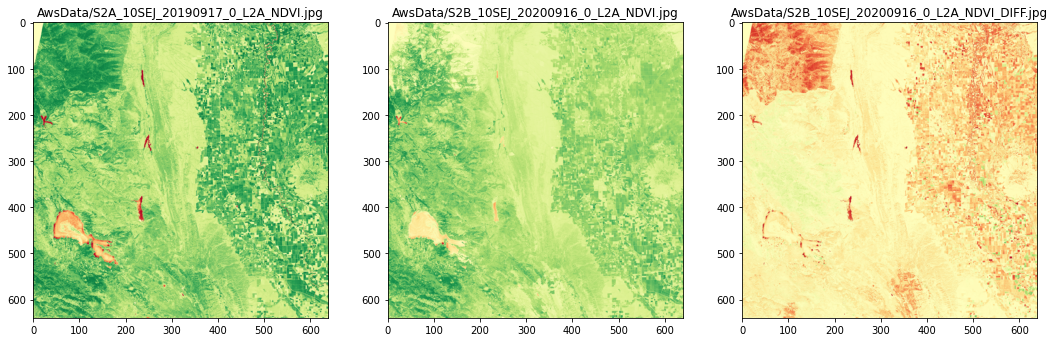

In [23]:
co_jpgs_f1 = [(res[0], res[1]) for res in grouped_results['S2A_10SEJ']]
co_jpgs_f2 = [(res[0], res[2]) for res in grouped_results['S2A_10SEJ']]
co_jpgs_diff = [(res[0], res[3]) for res in grouped_results['S2A_10SEJ']]

images = {}
with ThreadPoolExecutor(max_workers=3) as ex:
    fs = list(ex.map(get_jpg, [co_jpgs_f1, co_jpgs_f2, co_jpgs_diff]))

f, ax = plt.subplots(1,3, figsize=(18, 18))
i = 0
for j in sorted(images.keys()):
    ax[i].set_title(j)
    ax[i].imshow(images[j])
    i = i+1
plt.show() 

## KPIs

2022-06-10 10:05:16,154 [INFO] lithops.executors -- ExecutorID 87e882-1 - Creating execution plots


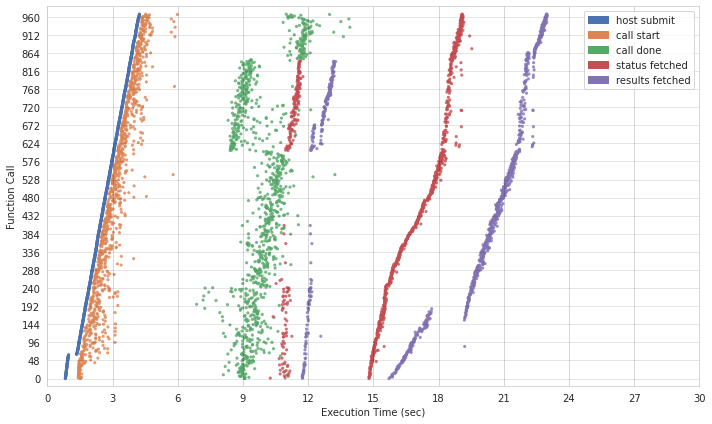

In [24]:
fexec.plot(dst=fexec.executor_id)

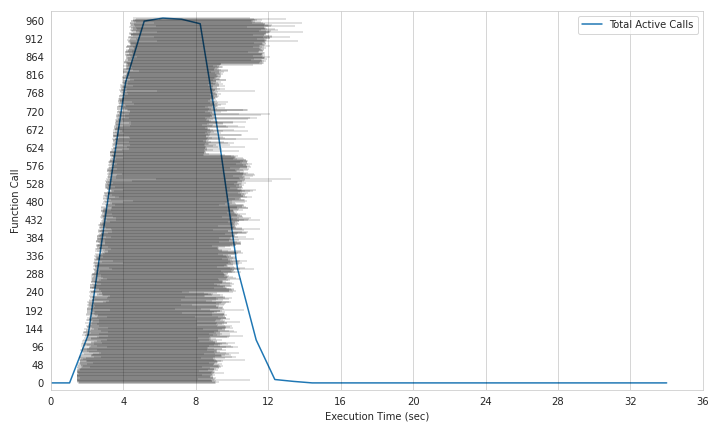

In [25]:
display.Image(filename=f'{fexec.executor_id}_histogram.png')

In [26]:
import boto3

s3client = boto3.client('s3')
total_sz = 0

for scenes in [scenes_f1_all, scenes_f2_all]:
    for scene in scenes:
        for band in scene:
            bucket, key = band.split('/', 1)
            meta = s3client.head_object(Bucket=bucket, Key=key)
            total_sz += int(meta['ResponseMetadata']['HTTPHeaders']['content-length'])

stats = [f.stats for f in fexec.futures]
mean_exec_time = np.mean([stat['worker_func_exec_time'] for stat in stats])
throughput = (total_sz / 1_000_000_000) / mean_exec_time

In [27]:
print(f'Procesed {round(total_sz / 1_000_000_000, 2)} GB in {round(mean_exec_time, 2)} s => {round(throughput, 2)} GB/s')

Procesed 5.44 GB in 4.37 s => 1.25 GB/s


In [28]:
gbxms_price = 0.0000000167
sum_total_time = sum([stat['worker_exec_time'] for stat in stats]) * 1000
price = gbxms_price * sum_total_time * 1  # Price GB/ms * sum of times in ms * 1 GB

In [29]:
print(f'Experiment total price is {round(price, 3)} USD')

Experiment total price is 0.11 USD
